Edge  Detector from Assigmnet 3 - Question 2.<br>
Shape Detector from Assigmnet 3 - Question 2.

In [16]:
# Imports
import cv2
import math
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import signal
import itertools

def zipAll(arr1, arr2):
    return list(itertools.product(arr1, arr2))

figsize = (15, 10)

# Print the full NumPy array
import sys
np.set_printoptions(threshold=sys.maxsize)

Text(0.5, 1.0, 'Original')

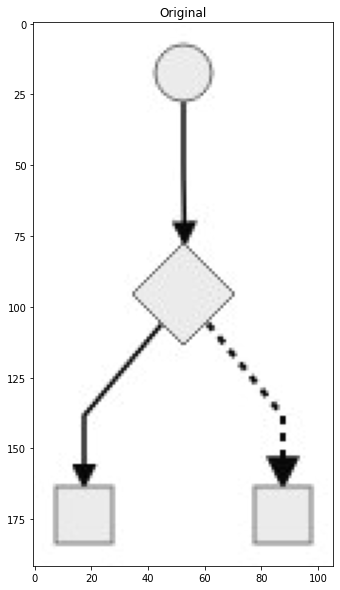

In [17]:
# Load the images in grayscale
#path = "Example2_smaller_file_size.jpg"
#path = "Digital.jpg"
path = "Digital_all_labels.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(img, cmap='gray')
ax.set_title("Original")

In [18]:
# Blur the image
if False:
    blur = cv2.blur(img, (5,5))
    
    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(blur, cmap='gray')
    ax.set_title("Blur")
else:
    blur = np.copy(img)

In [19]:
# Sharpen the image
if False:
    sharp_kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1],
    ])
    sharp = cv2.filter2D(blur, ddepth=cv2.CV_64F, kernel=sharp_kernel).astype(np.float)

    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(sharp, cmap='gray')
    ax.set_title("Sharp")
else:
    sharp = np.copy(blur)

Text(0.5, 1.0, 'Edge Detector')

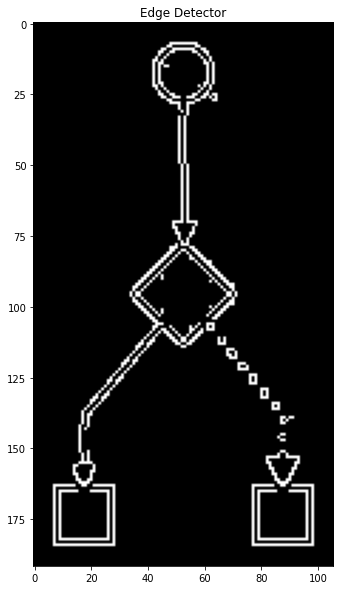

In [20]:
# Edge Detector
t1 = 20
t2 = t1 * 3
edges = cv2.Canny(blur, t1, t2)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Edge Detector")

In [21]:
'''
TODO:
  Optimization:
  * When choosing the range of sizes of the shapes (radii/width/height), check what is the maximum size that will fit inside the image
    and accordingly chose the size (minimum size is always 1, not 0).
  * When checking the threshold (e.g. "if lap[x][y] > 12000:"), also check if there is already a shape in the same area of the current shape,
    if there isn't, then add it normally, otherwise compare them, who has more "votes" and choose that one to be add
    (so we won't have 2 shapes in the same area).
    Need to take into consideration that each shape of each size can have differenet maximum amount of votes,
    so even if the shape is bigger it can get more votes than smaller size (even if the bigger one doesn't collect votes from all of his pixels),
    so maybe change it to % vote per shape?
'''

# Shape Detector
detect_circles = True
detect_rectangles = False
detect_rhombuses = False

# Initializing result arrays for circles
circles_center = []
circles_radius = []

# Initializing result arrays for rectangles
rectangles_center = []
rectangles_width = []
rectangles_height = []

# Initializing result arrays for rhombuses
rhombuses_center = []
rhombuses_width = []
rhombuses_height = []

y_max,x_max = img.shape
threshold = 0.90

In [22]:
if detect_circles:
    # Circle radius that will be checked
    radii = np.arange(10, math.ceil(min(y_max,x_max) / 2), step=2) # TODO: (10,11) is the correct choice; we need to change this from manual to automatically select (min can be 1 but max can't be TOO big, it will give us wrong answers, like 30 is already too much).
    
    # Creating all the circle's kernels according to the range of radius
    color = 1 # the circle will be 1s and the background 0s
    kernels = [ cv2.circle(np.zeros((radius * 2, radius * 2)), (radius, radius), radius, color) for radius in radii ]
    
    # Compute the accumulator for each possible radius
    houghs = [signal.convolve2d(edges, kernel, mode='same') for kernel in kernels]

    unique, counts = np.unique(kernel, return_counts=True)
    zero_one_dict = dict(zip(unique, counts))
    circumference = zero_one_dict[1]
    
    for index in range(len(radii)):
        hough = houghs[index]
        x_dim, y_dim = hough.shape
        for x in range(x_dim):
            for y in range(y_dim):
                if hough[y][x] / circumference > threshold: # TODO: 12200 to be exact
                    circles_center.append((y, x))
                    circles_radius.append(radii[index])

NameError: ignored

In [ ]:
if detect_rectangles:
    # Rectangle width and height that will be checked
    widths  = np.arange(21, 22) # TODO: change from manual to auto
    heights = np.arange(21, 22) # TODO: change from manual to auto
    sizes = zipAll(widths, heights)
    
    # Creating all the rectangle's kernels according to the range of width and height
    color = 1 # the rectangle will be 1s and the background 0s
    kernels = [ cv2.rectangle(np.zeros((height+1, width+1)), (0,0), (width, height), color) for width, height in sizes ]
    
    # Compute the accumulator for each possible radius
    houghs = [ signal.convolve2d(edges, kernel, mode='same') for kernel in kernels ]
    
    # Derivation of each hough via laplacian
    laplacian_kernel = np.array([
        [0, -1,  0],
        [-1, 4, -1],
        [0, -1,  0],
    ])
    laps = [ signal.convolve2d(hough, laplacian_kernel, mode='same') for hough in houghs ]
    
    for index in range(len(sizes)):
        lap = laps[index]
        x_dim, y_dim = lap.shape
        for x in range(x_dim):
            for y in range(y_dim):
                if lap[x][y] > 30000: # TODO: change from manual to auto
                    rectangles_center.append((y, x))
                    rectangles_width.append(sizes[index][0])
                    rectangles_height.append(sizes[index][1])

In [ ]:
# Note: We aren't search for rhombus,
# it's more of a rotated rectangle
# or parallelogram with right angles
# (since we assume hand drawn it won't have equal sides)
if detect_rhombuses:
    # Rhombus width and height that will be checked
    widths  = np.arange(25, 26) # TODO: change from manual to auto
    heights = np.arange(25, 26) # TODO: change from manual to auto
    sizes = zipAll(widths, heights)
    
    # Creating all the rhombus's kernels according to the range of width and height
    color = 1 # the rhombus will be 1s and the background 0s
    kernels = [0] * len(sizes)
    for index in range(len(sizes)):
        width, height = sizes[index]
        w = math.sqrt(math.pow(width,2)/2)
        h = math.sqrt(math.pow(height,2)/2)
        s = math.ceil(w+h)
        w = round(w)
        h = round(h)
        kernels[index] = cv2.polylines(np.zeros((s+1, s+1)), [np.array([ [[0, h]], [[w, s]], [[s, w]], [[h, 0]] ], np.int32)], True, color)
    
    # Compute the accumulator for each possible radius
    houghs = [ signal.convolve2d(edges, kernel, mode='same') for kernel in kernels ]

    # Derivation of each hough via laplacian
    laplacian_kernel = np.array([
        [0, -1,  0],
        [-1, 4, -1],
        [0, -1,  0],
    ])
    laps = [ signal.convolve2d(hough, laplacian_kernel, mode='same') for hough in houghs ]

    for index in range(len(sizes)):
        lap = laps[index]
        x_dim, y_dim = lap.shape
        for x in range(x_dim):
            for y in range(y_dim):
                if lap[x][y] > 22700: # TODO: change from manual to auto
                    rhombuses_center.append((y, x))
                    rhombuses_width.append(sizes[index][0])
                    rhombuses_height.append(sizes[index][1])

In [ ]:
# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(img, cmap='gray')
ax.set_title("Detected Shapes")

if detect_circles:
    # mark the center of the circles by a yellow point
    ax.plot([tpl[1] for tpl in circles_center],[tpl[0] for tpl in circles_center], 'o', color='yellow')
    # draw the circumference of the circles in blue
    for (y, x), radius in zip(circles_center, circles_radius):
        circ = plt.Circle((x, y), radius, color='blue', fill=False)
        ax.add_artist(circ)

if detect_rectangles:
    # mark the center of the rectangles by a red point
    ax.plot([tpl[0] for tpl in rectangles_center],[tpl[1] for tpl in rectangles_center], 'o', color='red')
    # draw the circumference of the rectangles in green
    for (y, x), width, height in zip(rectangles_center, rectangles_width, rectangles_height):
        dx = width/2
        dy = height/2
        rect = plt.Rectangle((y-dy,x-dx), width, height, 0.0, color='green', fill=False)
        ax.add_artist(rect)

if detect_rhombuses:
    # mark the center of the rhombuses by a orange point
    ax.plot([tpl[0] for tpl in rhombuses_center],[tpl[1] for tpl in rhombuses_center], 'o', color='orange')
    # draw the circumference of the rhombuses in purple
    for (y, x), width, height in zip(rhombuses_center, rhombuses_width, rhombuses_height):
        half_diagonal = norm([width, height])/2
        alpha = math.radians(45) + math.atan(height/width)
        dx = half_diagonal * math.sin(alpha)
        dy = half_diagonal * math.cos(alpha)
        rect = plt.Rectangle((y-dy,x-dx), width, height, 45.0, color='purple', fill=False) # 45 degree anti-clockwise
        ax.add_artist(rect)

In [ ]:
print(circles_center, circles_radius)
print(rectangles_center, rectangles_width, rectangles_height)
print(rhombuses_center, rhombuses_width, rhombuses_height)

In [ ]:
# Edge Detector - without shapes
edges_no_shape = np.copy(edges)
y_max, x_max = edges_no_shape.shape

color = 0 # shape and background will be 0
for center, radius in zip(circles_center, circles_radius):
    extra = 5
    edges_no_shape = cv2.circle(edges_no_shape, center, radius+extra, color, -1)
for (y, x), width, height in zip(rectangles_center, rectangles_width, rectangles_height):
    extra = 2
    dx = width/2
    dy = height/2
    top_left     = (max(round(y-dy-extra),     0), max(round(x-dx-extra),     0))
    bottom_right = (min(round(y+dy+extra), x_max), min(round(x+dx+extra), y_max))
    edges_no_shape = cv2.rectangle(edges_no_shape, top_left, bottom_right, color, -1)
for (y, x), width, height in zip(rhombuses_center, rhombuses_width, rhombuses_height):
    extra = 7
    width  += extra
    height += extra
    w = math.sqrt(math.pow(width,2)/2)
    h = math.sqrt(math.pow(height,2)/2)
    s = math.ceil(w+h)
    w = round(w)
    h = round(h)
    half_diagonal = norm([width, height])/2
    alpha = math.radians(45) + math.atan(height/width)
    dx = half_diagonal * math.sin(alpha)
    dy = dx
    y = round(y-dy)
    x = round(x-dx)
    edges_no_shape = cv2.fillPoly(edges_no_shape, [np.array([ [[y, x+h]], [[y+w, x+s]], [[y+s, x+w]], [[y+h, x]] ], np.int32)], color)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges_no_shape, cmap='gray')
ax.set_title("Edge Detector - without shapes")

In [ ]:
def RelaxationLabeling(image):
    #Initialize the confidence variable 
    #'confidence' is the confidence of label "1" for each pixel, and the confidence of
    #label "0" is the complimentary value (1-confidence)
    confidence = np.zeros_like(image).astype(np.float)
    # Initial confidence is determined such that black pixels have high confidence of being "object pixels"
    # and white pixels have low confidence of being "object pixels"
    image = image / 255
    confidence[image <  0.5] =   0.9999
    confidence[image >= 0.5] = 1-0.9999

    # We initialize the segmentation array with the labels at iteration 0
    segmentation_array = 1-image

    # Initialize the support variable
    support = np.zeros_like(image).astype(np.float)

    # We compute the compatibility as a weighted sum of the neighbors assignment using convolution
    # The computability is higher when the neighbors are mostly dark, and smaller when the neighbors are mostly bright.
    # Each of the neighbors is weighted by the probability of its current assignment - and the result is the support
    kernel = np.ones((3, 3)) / 9
  
    # "Stop" is a flag for when to stop the itertions
    stop = False
    
    # Initialize stopping criteria
    average_local_consistency = 0

    # run main part of the algorithm
    while stop==False:
        # 'support' is the support of label "1" for each pixel, and the support of label
        # "0" is the complimentary value (1-support)
        support = cv2.filter2D(segmentation_array*confidence, ddepth=cv2.CV_64F, kernel=kernel).astype(np.float)
        # Update the current assignment choosing the label with the highest support
        segmentation_array = (support >= 0.5)*1.0
        # Update the confidence
        consistency = confidence*support
        comp_consistency = (1-confidence)*(1-support)
        sum_consistency = consistency + comp_consistency 
        confidence = consistency / sum_consistency
        # Stopping criteria
        if (np.sum(sum_consistency)-average_local_consistency) < 0.1:
            stop=True
        else:
            average_local_consistency = np.sum(sum_consistency)

    return segmentation_array

In [ ]:
# Use the algorithm to segment the 2 grayscale images
segmented_images = RelaxationLabeling(edges_no_shape)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(segmented_images, cmap='gray')
ax.set_title("Segmented arrows")

In [ ]:
widths  = np.arange(190, 230, step=10) # np.arange(10, x_max) # TODO
heights = np.arange(50, 90, step=10) # np.arange(10, y_max) # TODO
sizes = zipAll(widths, heights)
length = len(sizes)
length
ls = [1,2,3]
a = list.reverse(ls)
ls